In [1]:
import radvel
import radvel.likelihood
import matplotlib.pyplot as plt
import numpy as np

import corner
import copy

from scipy import optimize

# Convenient function for plotting fits
def plot_results(like):
    fig = plt.gcf()
    plt.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')

Intialize Keplerian model parameters
====================================

In [2]:
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.1)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
params['dvdt'] = radvel.Parameter(value=0.0, vary=False)
params['curv'] = radvel.Parameter(value=0.0, vary=False)
rv_mod = radvel.RVModel(params)

Generate Synthetic Data
=======================

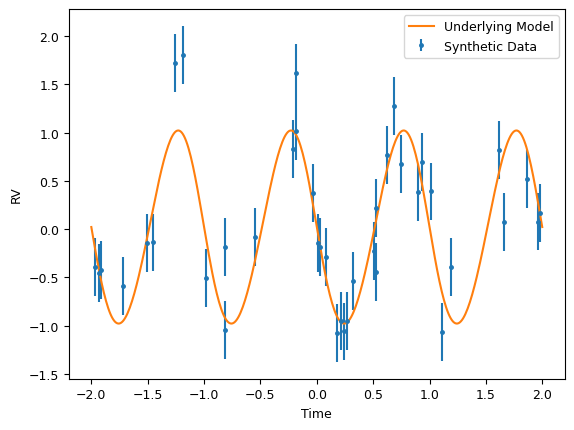

In [3]:
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
jitter = 0.3
syn_rv = rv_mod(t) + np.random.randn(t.size)*np.sqrt(errvel**2 + jitter**2)
plt.errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plt.plot(ti,rv_mod(ti),label='Underlying Model')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend()
plt.show()

Generate a likelihood
=====================

In [4]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,np.zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter

Perform a maximum likelihood fit
===============================

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 12.28856752367748
             x: [ 1.001e+00 -4.080e-02  4.162e-01  1.401e-01  1.021e+00
                  4.945e-02  1.350e-01]
           nit: 897
          nfev: 1342
 final_simplex: (array([[ 1.001e+00, -4.080e-02, ...,  4.945e-02,
                         1.350e-01],
                       [ 1.001e+00, -4.082e-02, ...,  4.944e-02,
                         1.350e-01],
                       ...,
                       [ 1.001e+00, -4.082e-02, ...,  4.944e-02,
                         1.350e-01],
                       [ 1.001e+00, -4.081e-02, ...,  4.948e-02,
                         1.350e-01]]), array([ 1.229e+01,  1.229e+01,  1.229e+01,  1.229e+01,
                        1.229e+01,  1.229e+01,  1.229e+01,  1.229e+01]))
parameter                     value      vary
per1                              1       True
tc1                             0.1       True
secosw1      

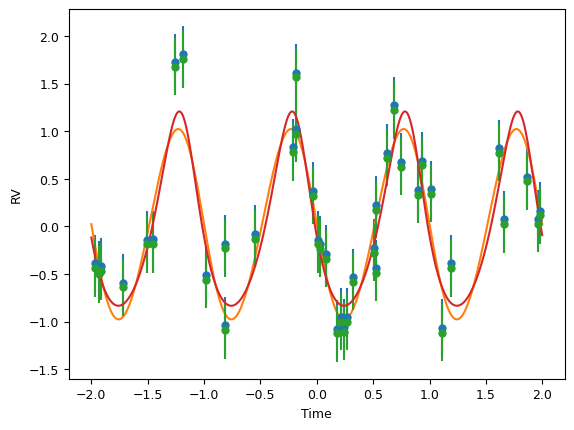

In [5]:
plot_results(like_syn) # Plot initial model
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model
plt.show()

Instantiate a posterior object
===============================

In [6]:
post = radvel.posterior.Posterior(like_syn)
post.params['per1'] = radvel.Parameter(value=1)
post.params['k1'] = radvel.Parameter(value=1)
post.params['jit'].vary = False
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

post.priors += [radvel.prior.SecondaryEclipsePrior(1, 0.5, 0.01)]

print(post)
# like_syn.name_vary_params()
# like_syn.vector.names
like_syn.params

parameter                     value      vary
per1                              1       True
tc1                             0.1       True
secosw1                         0.1       True
sesinw1                         0.1       True
k1                                3       True
dvdt                              0      False
curv                              0      False
gamma                             0       True
jit                             0.3      False
tp1                      -0.0205459           
e1                             0.02           
w1                         0.785398           

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1
secondary eclipse constraint: 0.5 +/- 0.01



Parameters([('per1',
             Parameter object: value = 1.0, vary = True, mcmc scale = None),
            ('tc1',
             Parameter object: value = 0.1, vary = True, mcmc scale = None),
            ('secosw1',
             Parameter object: value = 0.1, vary = True, mcmc scale = None),
            ('sesinw1',
             Parameter object: value = 0.1, vary = True, mcmc scale = None),
            ('k1',
             Parameter object: value = 3.0, vary = True, mcmc scale = None),
            ('dvdt',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('curv',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('gamma',
             Parameter object: value = 0.0, vary = True, mcmc scale = None),
            ('jit',
             Parameter object: value = 0.3, vary = False, mcmc scale = None)])

Perform maximum likelihood fit on posterior
=========================================

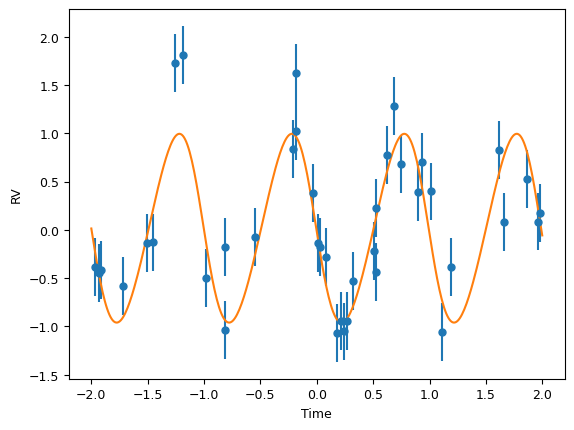

In [7]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
plot_results(post.likelihood)
plt.show()

Use mcmc to sample the posterior distribution
========================

1. use `emcee` package to run MCMC
1. corner plot visualizes parameters and correlations
1. Blue lines show the synthetic model parameters

In [8]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000,savename='rawchain.h5')

8000/160000 (5.0%) steps complete; Running 15988.14 steps/s; Mean acceptance rate = 54.2%; Min Auto Factor =  23; Max Auto Relative-Change =   inf; Min Tz = 2717.4; Max G-R = 1.010
Discarding burn-in now that the chains are marginally well-mixed

128000/160000 (80.0%) steps complete; Running 16238.64 steps/s; Mean acceptance rate = 46.4%; Min Auto Factor =  61; Max Auto Relative-Change = 0.0281; Min Tz = 6729.2; Max G-R = 1.004
Chains are well-mixed after 128000 steps! MCMC completed in 8.4 seconds




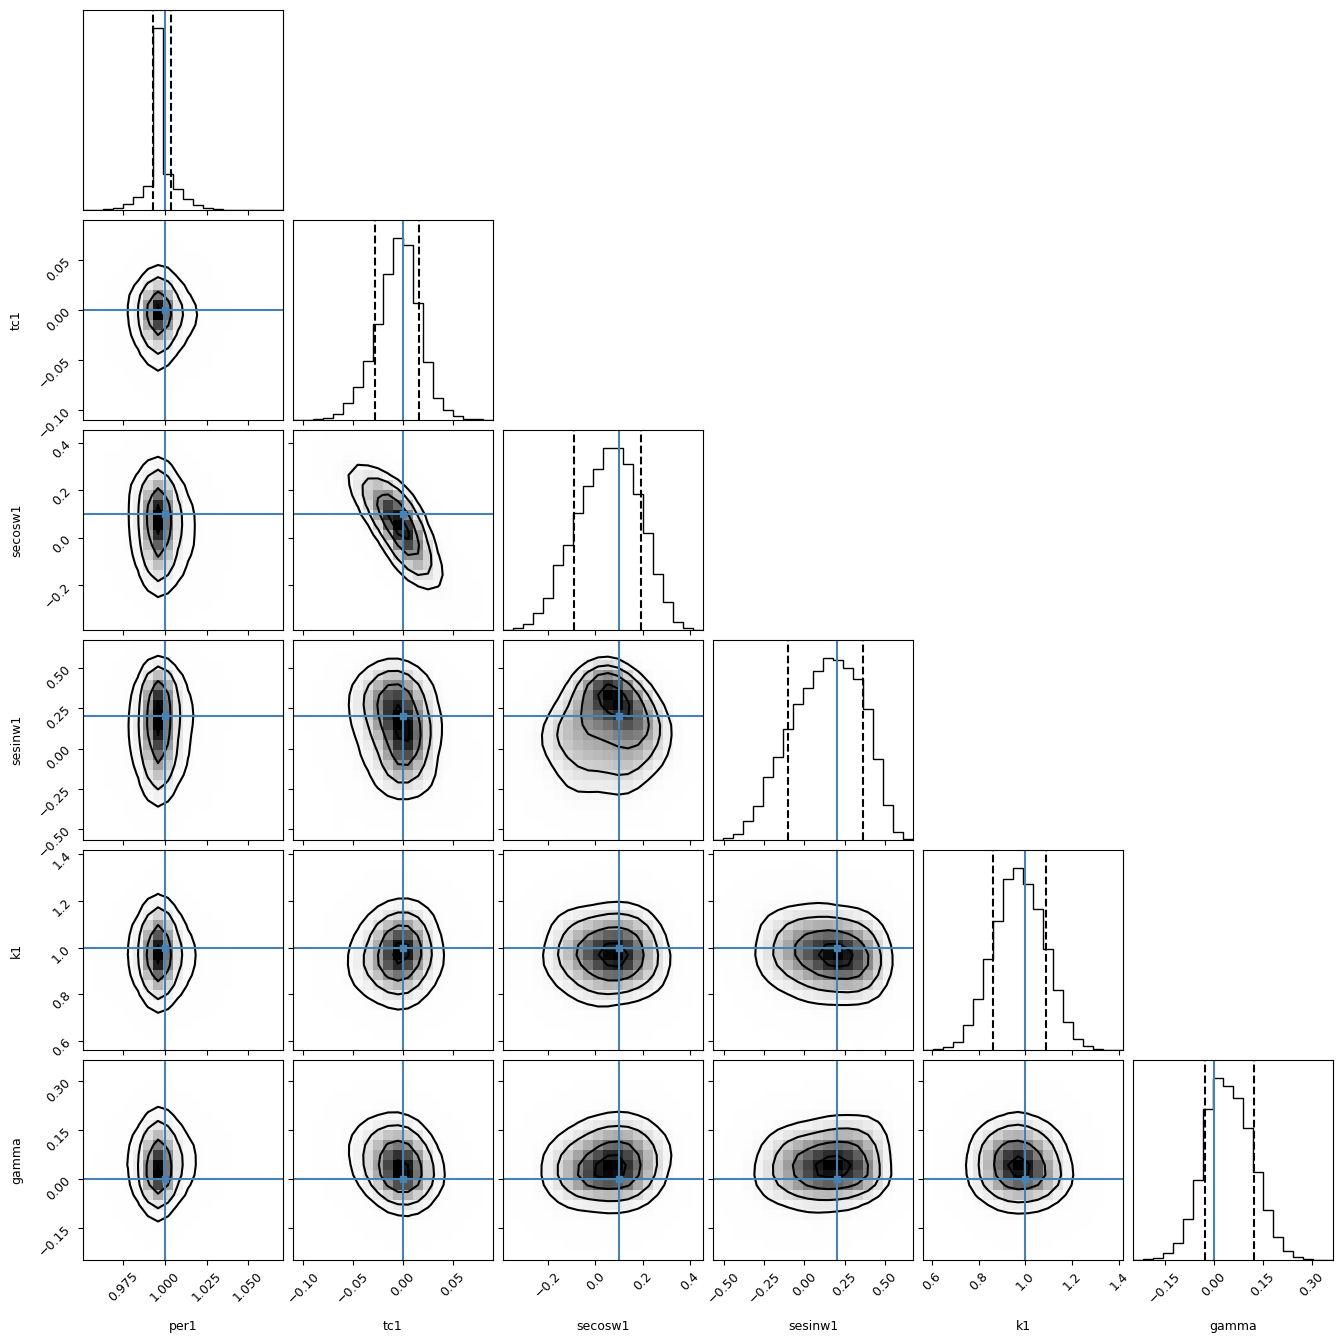

In [9]:
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
    df[labels],
    labels=labels,
    truths=[truths[k].value for k in labels ],
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )
plt.show()